In [42]:
#課題4-3

import numpy as np
import mnist
import matplotlib.pyplot as plt
from pylab import cm
import itertools

#乱数固定
np.random.seed(0)
#学習率
eta = 0.2
al = 0.9
#エポック数
epoch = 100
#画像サイズ
size = 28*28
#中間層の数
M = 50
#画像枚数
train_data_size = 50000
test_data_size = 10000
#クラス数
classes = 10
#データ
X = mnist.download_and_parse_mnist_file("train-images-idx3-ubyte.gz")
Y = mnist.download_and_parse_mnist_file("train-labels-idx1-ubyte.gz")
#バッチサイズ
B = 100
#dropout
rho = 0.1

#シグモイド関数
def sigmoid(x):
    s = 1.0 / (1.0 + np.exp(-x))
    return s

#ソフトマックス関数
def softmax(x):
    u = np.sum(np.exp(x),axis=0)
    return np.exp(x)/u

#ReLU
def ReLU(x):
    return np.clip(x, 0, None)

#ReLUの微分
def del_ReLU(x):
    return np.where(x > 0, 1, 0)


#乱数生成
W_1 = np.random.normal(0, np.sqrt(1/size),(M,size)) #M x size
b_1 = np.random.normal(0, np.sqrt(1/size),M) 
W_2 = np.random.normal(0, np.sqrt(1/M), (classes,M)) #classes x M
b_2 = np.random.normal(0, np.sqrt(1/M), classes)
gamma = np.ones((50,1))
beta = np.zeros((50,1))
delW_1 = delW_2 = delb_1 = delb_2 = delgamma = delbeta = 0

#クロスエントロピー
each_cross_entropy = 0


def dropout(rows, columns, rho):
    total_elements = rows * columns
    num_zeros = rho * total_elements  # 指定された割合に基づいて0の要素数を計算

    # 1で初期化された行列を作成
    matrix = np.ones((rows, columns))

    # 指定された割合の要素を0に設定
    zero_indices = np.random.choice(total_elements, int(num_zeros), replace=False)
    row_indices, col_indices = np.unravel_index(zero_indices, (rows, columns))
    matrix[row_indices, col_indices] = 0

    return matrix


def batch_normalization(x, gamma, beta):
    delta = 1e-7
    mini_ave = np.mean(x, axis = 1, keepdims =True) #列で足し算
    mini_var = np.var(x, axis = 1, keepdims = True)
    x = (x - mini_ave)/np.sqrt(mini_var + delta)
    y = gamma * x + beta
    
    return (mini_ave, mini_var, x, y)

def forward(W_1,W_2,b_1,b_2,data_size,gamma,beta):
    #ランダムなインデックス抽出
    minibach = np.random.choice(data_size, B, replace=False)
    
    #size x Bの行列へ変換
    X_matrix = []
    for i in range(B):
        X_matrix.append(X[minibach[i]].reshape([size]))
    X_matrix = np.array(X_matrix).T #size x B
    X_matrix = X_matrix/255
    
    #全結合層１のあとにバッチ正規化
    (mini_ave, mini_var, x, y) = batch_normalization(np.dot(W_1,X_matrix)+b_1[:,np.newaxis], gamma, beta)
    
    #中間層の出力
#     y_1 = ReLU(y) * dropout(M,B,rho) # M x B ReLU
    y_1 = sigmoid(np.dot(W_1,X_matrix)+b_1[:,np.newaxis]) # M x B sigmoid
    
    #ソフトマックス
    a = np.dot(W_2,y_1) + b_2[:,np.newaxis] # classes x B
    alpha = np.max(a,axis=0)#各列の最大値B個
    y_pred = softmax(a - alpha[np.newaxis,:]) #それぞれのバッチのソフトマックス #10 x B
    y_index_pred = np.argmax(y_pred,axis=0)  #それぞれのバッチの予測
    y_true = np.array([np.eye(10)[y] for y in Y[minibach]],dtype="int8").T  # 10 x B
    
    return(X_matrix, y_1, y_pred,y_index_pred, y_true, minibach)


def test_forward(W_1,W_2,b_1,b_2,train_data_size,test_data_size,gamma,beta):   

    #size x test_data_sizeの行列へ変換
    X_matrix = []
    for i in range(train_data_size,train_data_size + test_data_size):
        X_matrix.append(X[i].reshape([size]))
    X_matrix = np.array(X_matrix).T #size x test_data_size
    X_matrix = X_matrix/255
    
    #バッチ正規化
    (mini_ave, mini_var, x, y) = batch_normalization(np.dot(W_1,X_matrix)+b_1[:,np.newaxis], gamma, beta)

    E = np.sum(mini_ave)/test_data_size
    Var = np.sum(mini_var)/test_data_size
    y = (gamma * x / (Var + 1e-15)**(1/2)) + (beta - gamma*E/(Var + 1e-15)**(1/2))
    
      
    #中間層の出力
#     y_1 = ReLU(y) * (1 - rho) # M x test_data_size
    y_1 = sigmoid(np.dot(W_1,X_matrix)+b_1[:,np.newaxis]) # M x B sigmoid
    
    #ソフトマックス
    a = np.dot(W_2,y_1) + b_2[:,np.newaxis] # classes x test_data_size
    alpha = np.max(a,axis=0)#各列の最大値B個
    y_pred = softmax(a - alpha[np.newaxis,:]) #それぞれのバッチのソフトマックス #10 x test_data_size
    y_index_pred = np.argmax(y_pred,axis=0)  #それぞれのバッチの予測
    
    return y_index_pred


#シグモイドの微分
def del_sigmoid(y):
    return (1 - y)  * y


def backward(y_pred, y_true, y_1, X_matrix, W_1, W_2,b_1, b_2, gamma, beta,delW_1, delW_2,delb_1, delb_2, delgamma, delbeta):
#ソフトマックス関数プラスクロスエントロピー誤差の逆伝搬   
    #del En/del akを求める
    del_en_del_ak = (y_pred - y_true)/B #C x B
#中間層から出力層の逆伝播
    #del En/del X
    del_en_del_x = np.dot(W_2.T,del_en_del_ak) # M x B

    #del En/del W_2
    del_en_del_w_2 = np.dot(del_en_del_ak, y_1.T) #C x M
    
    #del En/del b_2
    del_en_del_b_2 = np.sum(del_en_del_ak,axis=1) #B


    
    #中間層の活性化関数の逆伝搬
#     del En/del X      ReLU    
#     del_en_del_x_1 = del_en_del_x * del_ReLU(y_1)
#     #del En/del X 　　sigmoid
    del_en_del_x_1 = del_en_del_x * del_sigmoid(y_1)
    
    
    #全結合層１のあとのバッチ正規化
    (mini_ave, mini_var, x, y) = batch_normalization(np.dot(W_1,X_matrix)+b_1[:,np.newaxis], gamma, beta)
    X_input = np.dot(W_1,X_matrix)+b_1[:,np.newaxis]
    
    
    #バッチ正規化の逆伝搬
    del_norm_x = del_en_del_x_1 * gamma
    del_var = np.sum(del_norm_x * (X_input - mini_ave)*(-1) / 2 * (mini_var + 1e-7) ** (-3/2), axis = 0, keepdims =True)
    del_ave = np.sum(del_norm_x * (-1)/ (mini_var + 1e-7) ** (1/2), axis = 0, keepdims =True) + del_var * np.sum((-2)*(X_input - mini_ave), axis = 0, keepdims =True) / B
    del_X = del_norm_x / (mini_var + 1e-7) ** (1/2) + del_var * 2 * (X_input - mini_ave) / B + del_ave / B
    del_gamma = np.sum(del_en_del_x_1 * x, axis = 1, keepdims =True)
    del_beta = np.sum(del_en_del_x_1, axis = 1, keepdims =True)
               
    
    #全結合層１の逆伝搬
    #del En/del W
    del_en_del_w_1 = np.dot(del_X, X_matrix.T)
    #del En/del b
    del_en_del_b_1 = np.sum(del_X, axis=1)

    

    #パラメータの更新
    delW_1 = delW_1 * al - (eta * del_en_del_w_1)
    W_1 = W_1 + delW_1
    delW_2 = delW_2 * al - (eta * del_en_del_w_2)
    W_2 = W_2 + delW_2
    delb_1 = delb_1 * al - (eta * del_en_del_b_1)
    b_1 = b_1 + delb_1
    delb_2 = delb_2 * al - (eta * del_en_del_b_2)
    b_2 = b_2 + delb_2
    delgamma = delgamma * al - (eta * del_gamma)
    gamma = gamma + delgamma
    delbeta = delbeta * al - (eta * del_beta)
    beta = beta + delbeta
    
    #クロスエントロピーの計算
    cross_entropy_list = -np.sum(y_true * np.log(y_pred + 1e-15),axis = 0)
    each_cross_entropy = np.sum(cross_entropy_list)/B
    
    return (each_cross_entropy,W_1,W_2,b_1,b_2,gamma,beta,delW_1, delW_2,delb_1, delb_2, delgamma, delbeta)



#正解率
def list_match_rate(list1, list2):
    # 2つのリストの要素数を取得
    len1 = len(list1)
    len2 = len(list2)

    # 空のリストが渡された場合、一致率は0とします
    if len1 == 0 or len2 == 0:
        return 0.0
    
    # 一致する要素の数を計算
    match_count = sum(1 for a, b in zip(list1, list2) if a==b)
    # 一致率を計算
    match_rate = match_count * 100 / len1
    
    return match_rate



#epoch
j = 0
entropy_list = []
x = list(range(epoch))
while (epoch > 0):
    j += 1
    print("epoch" + str(j))
    sum_entropy = 0
    
    W_1 = np.load("W1.npy")
    W_2 = np.load("W2.npy")
    b_1 = np.load("b1.npy")
    b_2 = np.load("b2.npy")
    gamma = np.load("gamma.npy")
    beta = np.load("beta.npy")
    delW_1 = np.load("delW1.npy")
    delW_2 = np.load("delW2.npy")
    delb_1 = np.load("delb1.npy")
    delb_2 = np.load("delb2.npy")
    delgamma = np.load("delgamma.npy")
    delbeta = np.load("delbeta.npy")

    
    y_all_true = []
    y_all_pred = []
    
    #繰り返し学習
    for i in range(int(train_data_size/B)):
        (X_matrix, y_1, y_pred,y_index_pred, y_true, minibach) = forward(W_1,W_2,b_1,b_2,train_data_size, gamma, beta)
        (each_cross_entropy,W_1,W_2,b_1,b_2,gamma,beta,delW_1, delW_2,delb_1, delb_2, delgamma, delbeta) = backward(y_pred, y_true, y_1, X_matrix, W_1, W_2,b_1, b_2, gamma, beta,delW_1, delW_2,delb_1, delb_2, delgamma, delbeta)

        sum_entropy += each_cross_entropy
        y_all_true.append(Y[minibach])
        y_all_pred.append(y_index_pred)
    cross_entropy = sum_entropy*B/train_data_size
    print("クロスエントロピー:"+ str(cross_entropy))
    entropy_list.append(cross_entropy)
    print("正解率" + str(list_match_rate(np.array(y_all_true).ravel(), np.array(y_all_pred).ravel())))#ミニバッチの正解率
    
    #保存
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/W1_test.npy",W_1)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/W2_test.npy",W_2)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/b1_test.npy",b_1)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/b2_test.npy",b_2)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/gamma_test.npy",gamma)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/beta_test.npy",beta)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/delW1_test.npy",delW_1)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/delW2_test.npy",delW_2)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/delb1_test.npy",delb_1)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/delb2_test.npy",delb_2)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/delgamma_test.npy",delgamma)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/delbeta_test.npy",delbeta)

    np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/W1.npy",W_1)
    np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/W2.npy",W_2)
    np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/b1.npy",b_1)
    np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/b2.npy",b_2)
    np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/gamma.npy",gamma)
    np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/beta.npy",beta)
    np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/delW1.npy",delW_1)
    np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/delW2.npy",delW_2)
    np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/delb1.npy",delb_1)
    np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/delb2.npy",delb_2)
    np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/delgamma.npy",delgamma)
    np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/delbeta.npy",delbeta)
    #テストデータで評価
    y_index_pred = test_forward(W_1,W_2,b_1,b_2,train_data_size,test_data_size,gamma,beta)
    number_list = list(range(train_data_size, train_data_size + test_data_size))
    print("テスト正解率" + str(list_match_rate(Y[number_list], y_index_pred)))
    epoch -= 1
    
#結果
plt.plot(x,entropy_list)
plt.xlabel("epoch")
plt.ylabel("entropy")
plt.show()

epoch1
クロスエントロピー:0.0013514661348048114
正解率100.0
テスト正解率97.03
epoch2
クロスエントロピー:0.001358791604834211
正解率100.0
テスト正解率97.06
epoch3
クロスエントロピー:0.0012716085068635626
正解率100.0
テスト正解率97.0
epoch4
クロスエントロピー:0.0013281759060200528
正解率100.0
テスト正解率97.08
epoch5
クロスエントロピー:0.001313518394415867
正解率100.0
テスト正解率96.96
epoch6
クロスエントロピー:0.0012818799088658776
正解率100.0
テスト正解率96.98
epoch7
クロスエントロピー:0.0012470641576852164
正解率100.0
テスト正解率97.03
epoch8
クロスエントロピー:0.0011823238413182981
正解率100.0
テスト正解率97.11
epoch9
クロスエントロピー:0.0011742360417456188
正解率100.0
テスト正解率97.02
epoch10
クロスエントロピー:0.0011990891355825955
正解率100.0
テスト正解率97.12
epoch11
クロスエントロピー:0.001127822309061675
正解率100.0
テスト正解率97.02
epoch12
クロスエントロピー:0.0011666858108584904
正解率100.0
テスト正解率97.02
epoch13
クロスエントロピー:0.0011014229967192927
正解率100.0
テスト正解率97.1
epoch14
クロスエントロピー:0.0011073623904021908
正解率100.0
テスト正解率96.97
epoch15
クロスエントロピー:0.0010648572761735224
正解率100.0
テスト正解率96.99
epoch16
クロスエントロピー:0.0010814677272425067
正解率100.0
テスト正解率97.02
epoch17
クロスエントロピー:0.001067528547537783

KeyboardInterrupt: 

In [3]:
#課題５

import numpy as np
import mnist
import matplotlib.pyplot as plt
from pylab import cm

#画像サイズ
size = 28*28
#中間層の数
M = 50
#クラス数
classes = 10
#テストデータ
X = mnist.download_and_parse_mnist_file("t10k-images-idx3-ubyte.gz")
Y = mnist.download_and_parse_mnist_file("t10k-labels-idx1-ubyte.gz")


#キーボードからの入力

try:
    idx = int(input("0から9999の中で好きな数字を入力してください"))
    
except ValueError:
    print("エラー: 数値以外の入力が検出されました。")
    exit()
    
else:
    if (idx < 0 or idx > 9999):
        print("エラー: 範囲外数値の入力が検出されました。")
        exit()
    else:
        #size次元ベクトルへ変換
        X_vector = X[idx].reshape([size])
        X_vector = X_vector/255
        #シグモイド関数
        def sigmoid(x):
            return 1.0 / (1.0 + np.exp(-x))
        #ソフトマックス関数
        def softmax(x):
            u = np.sum(np.exp(x))
            return np.exp(x)/u
        #乱数生成
        W_1 = np.load("W1.npy")
        W_2 = np.load("W2.npy")
        b_1 = np.load("b1.npy")
        b_2 = np.load("b2.npy")
        gamma = np.load("gamma.npy")
        beta = np.load("beta.npy")
        #中間層の出力
        y_1 = sigmoid(np.dot(W_1,X_vector)+b_1)

        #出力
        a = np.dot(W_2,y_1) + b_2
        alpha = np.full(classes,np.amax(a))
        y_2 = softmax(a-alpha)
        y = np.argmax(y_2)
        #結果
        plt.imshow(X[idx], cmap=cm.gray)
        plt.show()
        print("正しい結果: " + str(Y[idx]))
        print("予想結果: " + str(y))

0から9999の中で好きな数字を入力してください s


エラー: 数値以外の入力が検出されました。


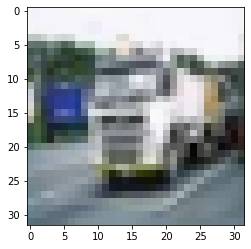

9


In [1]:
#発展課題A

import numpy as np
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo,encoding='bytes')
    X = np.array(dict[b'data'])
    X = X.reshape((X.shape[0],3,32,32))
    Y = np.array(dict[b'labels'])
    return X,Y

X,Y = unpickle("./cifar-10-batches-py//data_batch_1")

import matplotlib.pyplot as plt
idx = 1000
plt.imshow(X[idx].transpose((1,2,0))) # X[idx] が (3*32*32) になっているのを (32*32*3) に変更する．
plt.show() #トラックの画像が表示されるはず
print(f'{Y[idx]}') #9番（truck）が表示されるはず